## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
MODE = ['best_on','best_off','weight_on']

In [8]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint
model_ckpt1 = ModelCheckpoint(filepath="./tmp1.h5", 
                             monitor="val_loss", 
                             save_best_only=True)
from keras.callbacks import ModelCheckpoint
model_ckpt2 = ModelCheckpoint(filepath="./tmp2.h5", 
                             monitor="val_loss", 
                             save_best_only=False)
from keras.callbacks import ModelCheckpoint
model_ckpt3 = ModelCheckpoint(filepath="./tmp3.h5", 
                             monitor="val_loss", 
                             save_weights_only=True)

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for mode in MODE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape[1:])

    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    if mode == 'best_on':
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[model_ckpt1])
    elif mode == 'best_off':
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[model_ckpt2])
    else:
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[model_ckpt3])

    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" %(mode)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 7s 148us/step - loss: 0.1751 - acc: 0.9528 - val_loss: 2.5633 - val_acc: 0.4590
Epoch 50/50
50000/50000 [==============================] - 7s 149us/step - loss: 0.1726 - acc: 0.9507 - val_loss: 2.3806 - val_acc: 0.4834
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
________

50000/50000 [==============================] - 8s 151us/step - loss: 0.1967 - acc: 0.9457 - val_loss: 2.3401 - val_acc: 0.4733
Epoch 48/50
50000/50000 [==============================] - 7s 145us/step - loss: 0.1857 - acc: 0.9500 - val_loss: 2.5051 - val_acc: 0.4685
Epoch 49/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.1792 - acc: 0.9514 - val_loss: 2.4318 - val_acc: 0.4682
Epoch 50/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.1689 - acc: 0.9550 - val_loss: 2.4573 - val_acc: 0.4705
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048 

50000/50000 [==============================] - 7s 142us/step - loss: 0.2318 - acc: 0.9328 - val_loss: 2.3468 - val_acc: 0.4673
Epoch 46/50
50000/50000 [==============================] - 7s 146us/step - loss: 0.2181 - acc: 0.9376 - val_loss: 2.4165 - val_acc: 0.4478
Epoch 47/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.2088 - acc: 0.9416 - val_loss: 2.4540 - val_acc: 0.4698
Epoch 48/50
50000/50000 [==============================] - 8s 159us/step - loss: 0.1931 - acc: 0.9466 - val_loss: 2.2970 - val_acc: 0.4829
Epoch 49/50
50000/50000 [==============================] - 8s 155us/step - loss: 0.1790 - acc: 0.9507 - val_loss: 2.4700 - val_acc: 0.4701
Epoch 50/50
50000/50000 [==============================] - 8s 155us/step - loss: 0.1764 - acc: 0.9532 - val_loss: 2.4218 - val_acc: 0.4639


In [13]:
# Load back
model = keras.models.load_model("./tmp1.h5")
loss_loadback1, acc_loadback1 = model.evaluate(x_test, y_test)
model = keras.models.load_model("./tmp2.h5")
loss_loadback2, acc_loadback2 = model.evaluate(x_test, y_test)
model.load_weights("./tmp3.h5")
loss_loadback3, acc_loadback3 = model.evaluate(x_test, y_test)
print (loss_loadback1, acc_loadback1)
print (loss_loadback2, acc_loadback2)
print (loss_loadback3, acc_loadback3)

10000/10000 [==============================] - 2s 170us/step
1.4194306499481202 0.5062
2.4573111015319826 0.4705
2.4218217617034914 0.4639


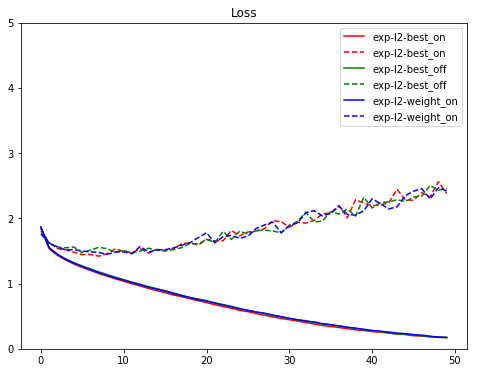

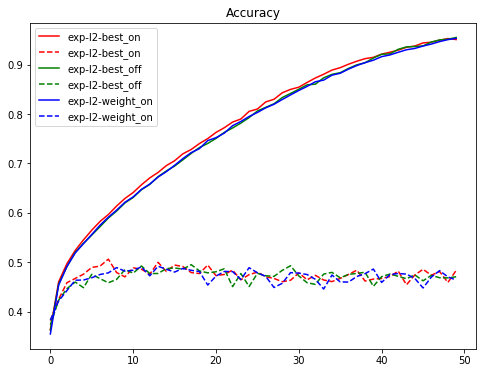

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()